In [1]:
import pandas as pd
df = pd.read_csv("crop_production.csv")
df.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


In [2]:
df.isnull().sum()

State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64

In [3]:
df = df.dropna()
df.isnull().sum()

State_Name       0
District_Name    0
Crop_Year        0
Season           0
Crop             0
Area             0
Production       0
dtype: int64

In [4]:
df.describe(include='all')

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
count,242361,242361,242361.000000,242361,242361,2.423610e+05,2.423610e+05
unique,33,646,NaN,6,124,NaN,NaN
top,Uttar Pradesh,TUMKUR,NaN,Kharif,Rice,NaN,NaN
freq,33189,931,NaN,94283,15082,NaN,NaN
mean,NaN,NaN,2005.625773,NaN,NaN,1.216741e+04,5.825034e+05
std,NaN,NaN,4.958285,NaN,NaN,5.085744e+04,1.706581e+07
min,NaN,NaN,1997.000000,NaN,NaN,1.000000e-01,0.000000e+00
25%,NaN,NaN,2002.000000,NaN,NaN,8.700000e+01,8.800000e+01
50%,NaN,NaN,2006.000000,NaN,NaN,6.030000e+02,7.290000e+02
75%,NaN,NaN,2010.000000,NaN,NaN,4.545000e+03,7.023000e+03


In [5]:
from sklearn import preprocessing

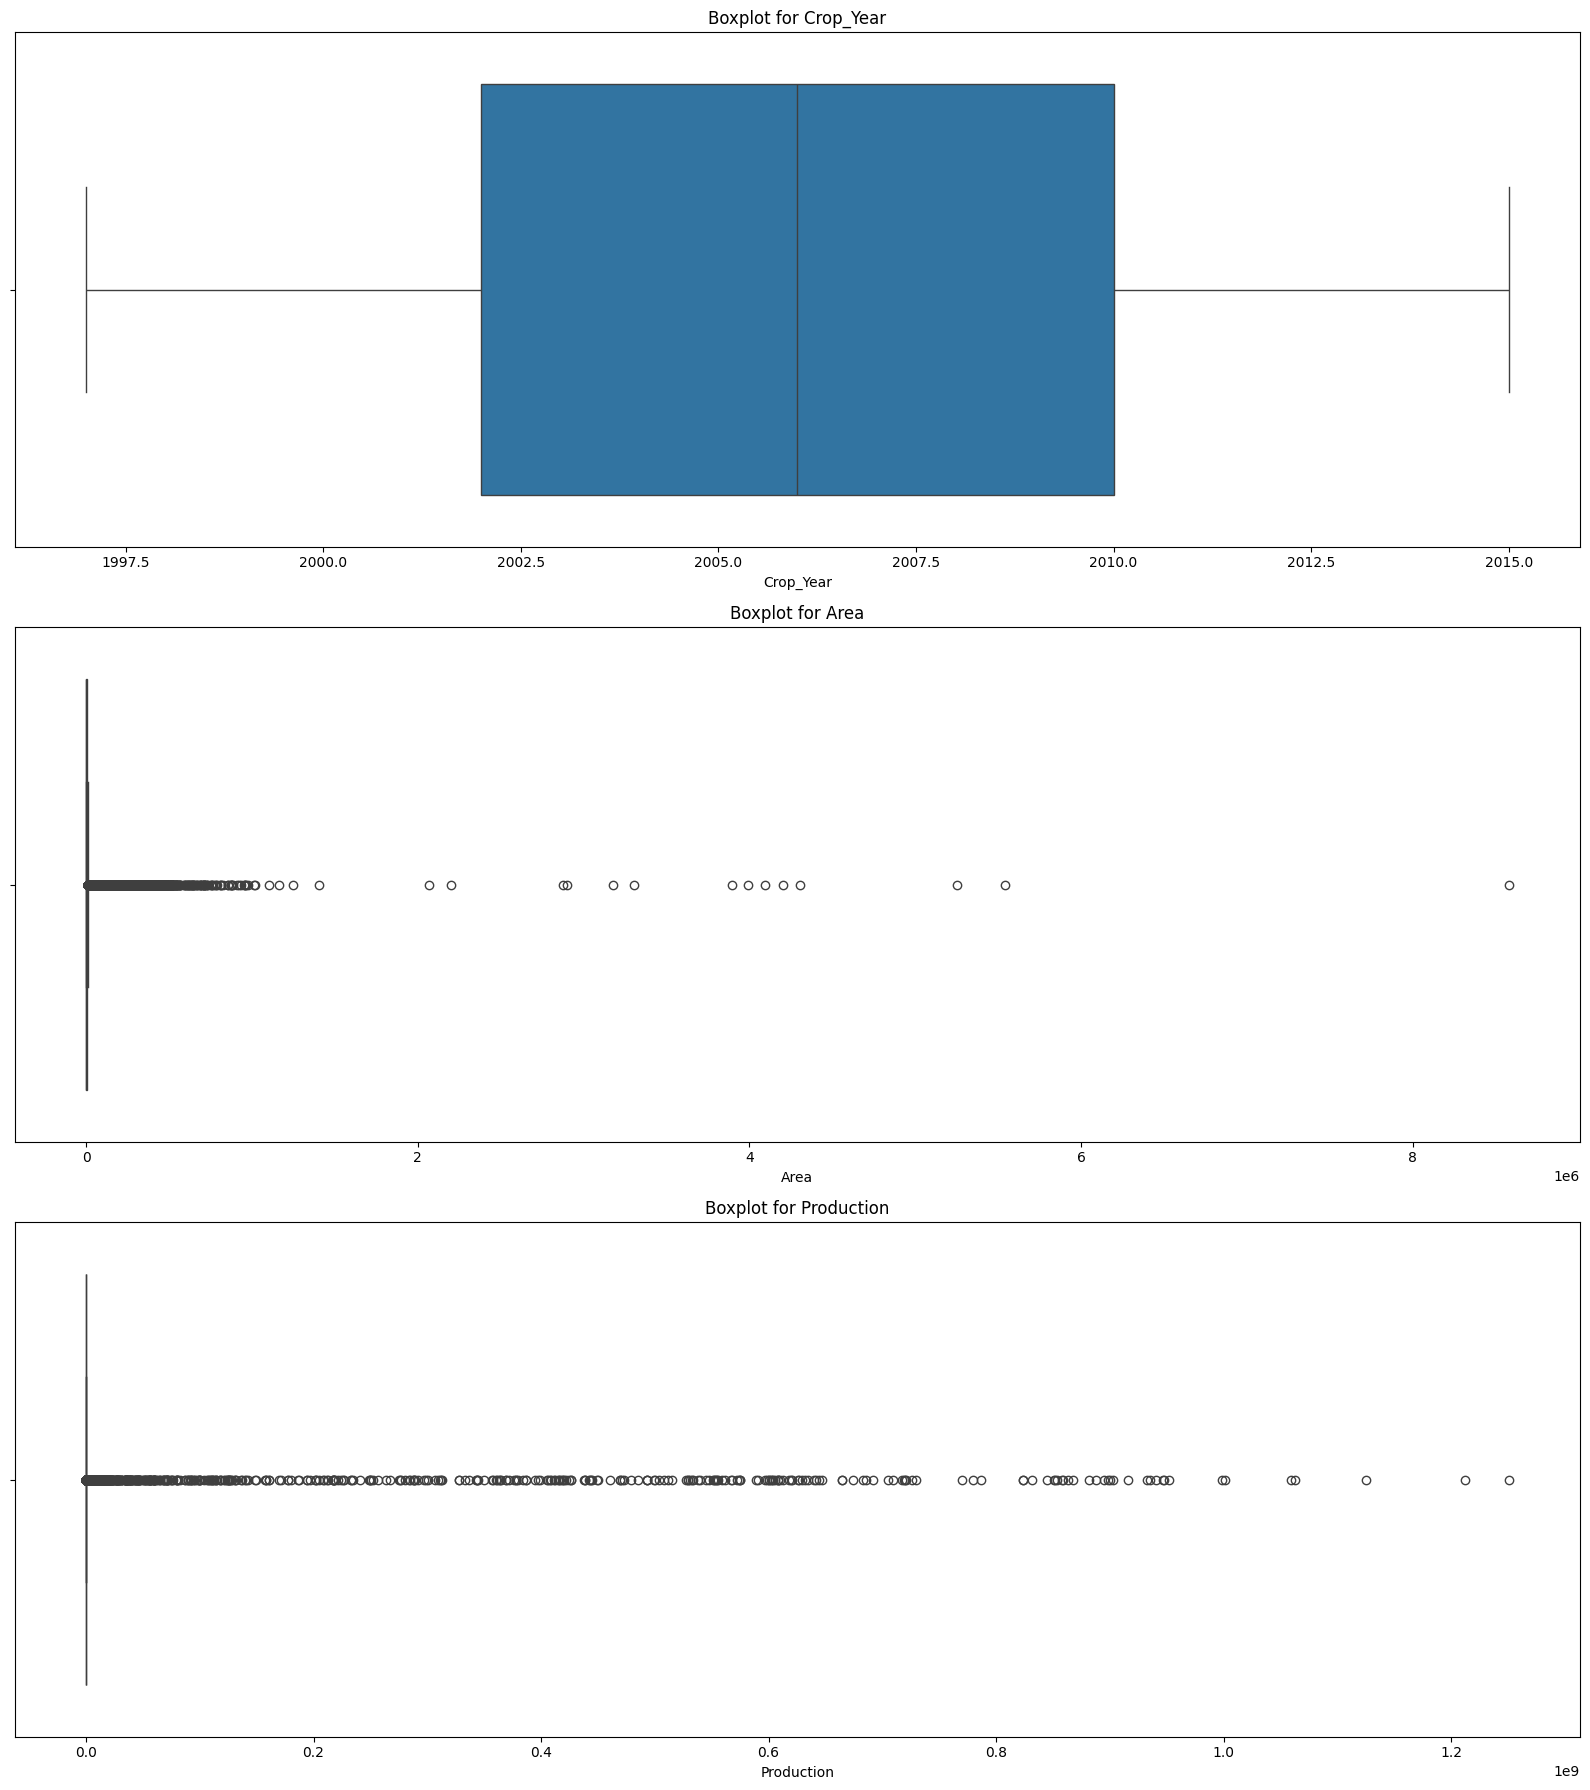


🔍 Outlier Counts (using IQR):
Crop_Year: 0 outliers
Area: 39930 outliers
Production: 42390 outliers


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
 # Replace with your file path

# Select only numerical columns (default variables)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Plot boxplots for each numerical variable
plt.figure(figsize=(16, 6 * len(numerical_cols)))

outlier_counts = {}

for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, idx)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    
    # Calculate IQR to find outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

plt.tight_layout()
plt.show()

# Print outlier counts
print("\n🔍 Outlier Counts (using IQR):")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import json

# Assuming df is your DataFrame

# 1. Load encoders
season_encoder = joblib.load('season_onehot_encoder.pkl')
state_encoder = joblib.load('state_label_encoder.pkl')

# 2. Apply One-Hot Encoding to Season (already done and saved)
season_encoded = season_encoder.transform(df[['Season']])

# 3. Apply Label Encoding to State (already done and saved)
state_encoded = state_encoder.transform(df['State_Name'])

# 4. Apply Target Mean Encoding for District and Crop (already done and saved)
with open('district_crop_mean_prod.json', 'r') as f:
    target_mean_dict = json.load(f)

df['district_crop_encoded'] = df.apply(lambda row: target_mean_dict.get(f"{row['District_Name']}_{row['Crop']}", 0), axis=1)

# 5. Apply Log Transformation for Area
df['Area_log'] = np.log1p(df['Area'])

# 6. Preparing final feature matrix
X = np.hstack([season_encoded, state_encoded.reshape(-1, 1), 
               df['district_crop_encoded'].values.reshape(-1, 1), 
               df['Area_log'].values.reshape(-1, 1)])

# Target variable
y = np.log1p(df['Production'])  # Log transformation for production

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CropYieldMLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        super(CropYieldMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
x
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.output(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = CropYieldMLP(input_dim)

# Loss and optimizer




In [9]:
import os
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def train_mlp_model(
    model, X, y, optimizer, criterion, epochs=500, batch_size=64,
    error_threshold=0.1, scheduler=None, validation_split=0.2,
    checkpoint_path='mlp_checkpoint.pth'
):
    """
    Train MLP model with validation set, scheduler, and checkpointing.
    """
    start_epoch = 0
    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_mse': [],
        'val_r2': [], 'val_accuracy': []
    }

    # Load checkpoint if it exists
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Loaded checkpoint from epoch {start_epoch}")

    # Split into train/validation sets
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    for epoch in range(start_epoch, epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            batch_data = X_train[i:i + batch_size]
            batch_labels = y_train[i:i + batch_size]
            optimizer.zero_grad()
            predictions = model(batch_data)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            val_mae = mean_absolute_error(y_val.numpy(), val_preds.numpy())
            val_mse = mean_squared_error(y_val.numpy(), val_preds.numpy())
            val_r2 = r2_score(y_val.numpy(), val_preds.numpy())

            # Accuracy within threshold
            diff = np.abs(val_preds.numpy() - y_val.numpy())
            non_zero_mask = y_val.numpy() != 0
            error_ratio = np.zeros_like(y_val.numpy(), dtype=float)
            error_ratio[non_zero_mask] = diff[non_zero_mask] / y_val.numpy()[non_zero_mask]
            val_accuracy = np.mean(error_ratio <= error_threshold) * 100

        # Scheduler step
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # Log history
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_mse'].append(val_mse)
        history['val_r2'].append(val_r2)
        history['val_accuracy'].append(val_accuracy)

        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'history': history
            }, checkpoint_path)

        # Print log
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | "
                  f"MAE: {val_mae:.4f} | MSE: {val_mse:.4f} | R2: {val_r2:.4f} | Accuracy: {val_accuracy:.2f}%")

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0, 0].plot(history['train_loss'], label='Train Loss')
    axs[0, 0].plot(history['val_loss'], label='Val Loss')
    axs[0, 0].set_title('Loss over Epochs')
    axs[0, 0].legend()

    axs[0, 1].plot(history['val_mae'], label='Val MAE', color='orange')
    axs[0, 1].set_title('Validation MAE')

    axs[1, 0].plot(history['val_mse'], label='Val MSE', color='green')
    axs[1, 0].set_title('Validation MSE')

    axs[1, 1].plot(history['val_r2'], label='Val R2', color='red')
    axs[1, 1].set_title('Validation R2')

    for ax in axs.flat:
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Metric")
        ax.legend()

    plt.tight_layout()
    plt.show()

    return history


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/var/folders/4f/2nsm3sqn5b9_2nbs_3xv3cc80000gn/T/ipykernel_32096/1984308405.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

Loaded checkpoint from epoch 62


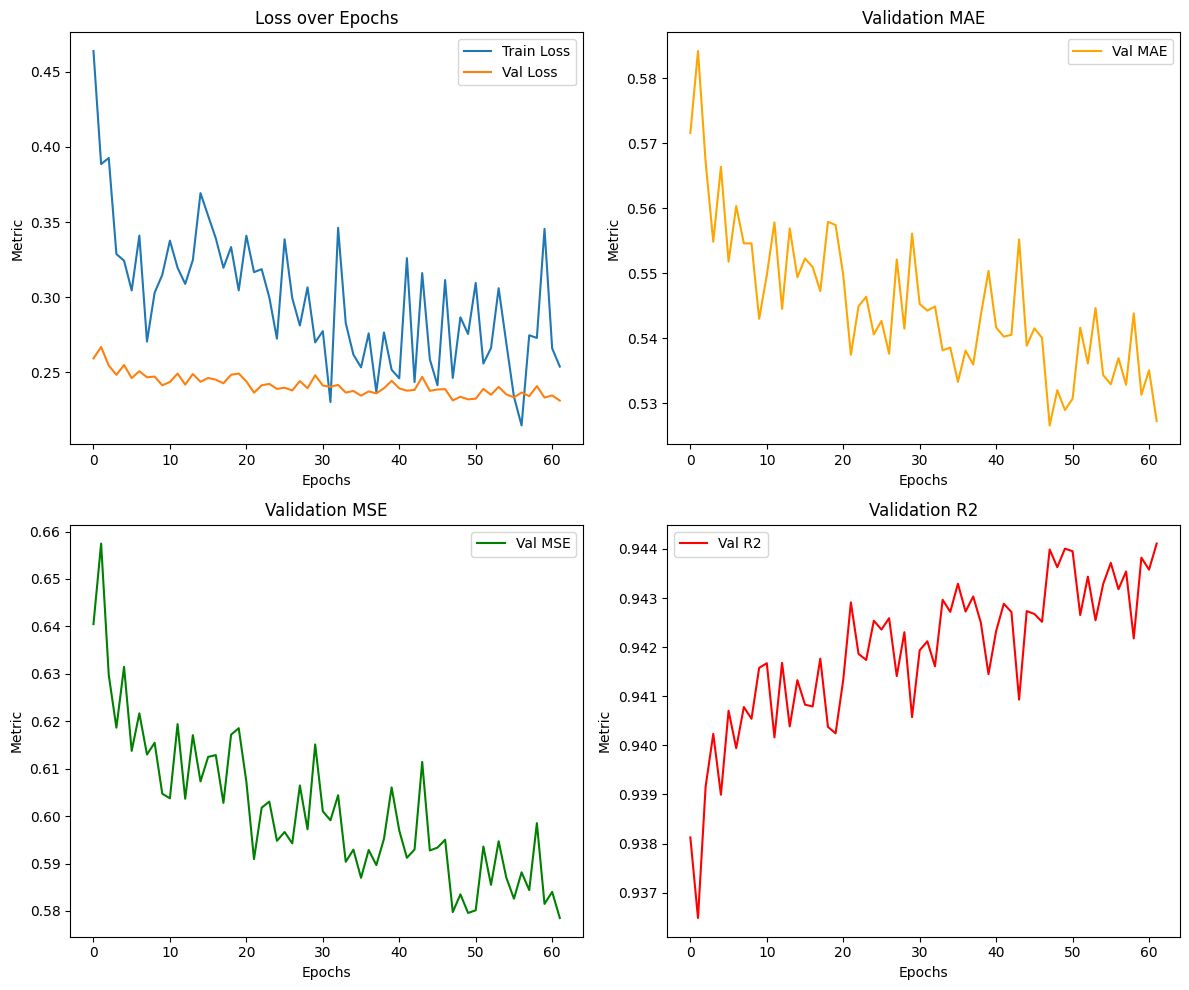

In [11]:
# After defining your optimizer:
import torch.optim as optim

criterion = nn.SmoothL1Loss()
# For regression tasks
optimizer = optim.AdamW(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.7, verbose=True)
# Train
history = train_mlp_model(model, X, y, optimizer, criterion, scheduler=scheduler,epochs=1)

In [12]:
import torch
# Save only the model parameters (recommended)
torch.save(model.state_dict(), 'my_model_weights.pth')

In [13]:
torch.save(model, 'my_model_complete.pth')
